<a href="https://colab.research.google.com/github/ArpanSM/MachineLearningHackathons/blob/master/JanataHack_Computer_Vision_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#download data
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_SOaYf6m.zip
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_vc2kHdQ.csv
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_yxjOnvz.csv
!unzip /content/train_SOaYf6m.zip
#libraries
import pandas as pd
import cv2
import numpy as np
#input data
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test_vc2kHdQ.csv")
sub=pd.read_csv("/content/sample_submission_yxjOnvz.csv")
#install
!pip install livelossplot

In [ ]:
import keras
from keras import optimizers
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten,GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping



```
#input shape according to pre trainied network
# ResNet50 --> 384
# VGG16 -- > 224
# VGG19 --> 224
# Xception --> 224
# InceptionV3 --> 224
```



## ResNet50

In [ ]:
img_size = 384

In [ ]:
#resizing and shaping images for transfer learning with ResNet50
img=[]
filename=train.image_names
for file in filename:
    image=cv2.imread("/content/images/"+file)
    res=cv2.resize(image,(img_size,img_size))
    img.append(res)
img=np.array(img)
print(img.shape)

(1646, 384, 384, 3)


In [ ]:
#splitting data for training and validation
train, val = train_test_split(train, test_size = 0.2)

#data augmentation
train_datagen = ImageDataGenerator( horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    fill_mode='nearest',
                                    shear_range=0.1,
                                    rescale=1/255)
train_generator=train_datagen.flow_from_dataframe(train,directory='/content/images',
                                                      target_size=(img_size,img_size),
                                                      x_col="image_names",
                                                      y_col="emergency_or_not",
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      subset='training',
                                                      batch_size=5)

val_datagen = ImageDataGenerator(rescale=1. / 255)
val_generator=val_datagen.flow_from_dataframe(val,directory='/content/images',
                                                      target_size=(img_size,img_size),
                                                      x_col="image_names",
                                                      y_col="emergency_or_not",
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=5)

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator=test_datagen.flow_from_dataframe(test,directory='/content/images',
                                                      target_size=(img_size,img_size),
                                                      x_col="image_names",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=5)

Found 1316 validated image filenames.
Found 330 validated image filenames.
Found 706 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


In [ ]:
x = model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.000005, 
                             beta_1=0.9,
                             beta_2=0.999,
                             amsgrad=False)

model_finetuned = Model(inputs=model_finetuned.input,
                        outputs=predictions)

model_finetuned.compile(optimizer=adam,
                        loss = 'binary_crossentropy',
                        metrics=['accuracy'])

#model_finetuned.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3,
                              patience=3,
                              min_lr=0.000001)


checkpoint = ModelCheckpoint("./model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5",
                             monitor="val_loss",
                             mode="auto",
                             save_best_only = True,
                             verbose=1)

callbacks = [PlotLossesKeras(),reduce_lr]

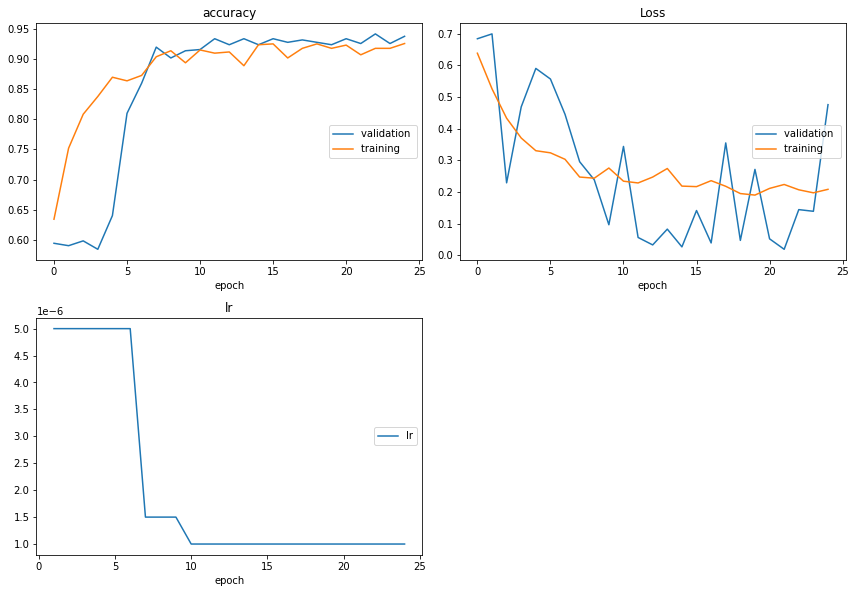

accuracy
	validation       	 (min:    0.584, max:    0.942, cur:    0.938)
	training         	 (min:    0.634, max:    0.926, cur:    0.926)
Loss
	validation       	 (min:    0.019, max:    0.699, cur:    0.476)
	training         	 (min:    0.190, max:    0.638, cur:    0.209)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [ ]:
history = model_finetuned.fit_generator(train_generator,
                                        steps_per_epoch=100,
                                        epochs=25,
                                        validation_data=val_generator,
                                        validation_steps=100,
                                        callbacks = callbacks,
                                        use_multiprocessing=False,
                                        shuffle=True)

In [ ]:
out = model_finetuned.predict(test_generator, verbose=1)
out_proba = out

142/142 [==============================] - 25s 179ms/step


In [ ]:
for i in range(len(out)):
  if(out_proba[i]>0.5):
    out[i]=1
  else:
    out[i]=0

In [ ]:
sub['emergency_or_not'] = out.astype(int)
sub.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


In [ ]:
sub.to_csv('submission_RESNET.csv', index=False)